### Use LeNet to get a 84 dim embedding 

In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Experiments
We'll go through learning feature embeddings using different loss functions on MNIST dataset. This is just for visualization purposes, thus we'll be using 2-dimensional embeddings which isn't the best choice in practice.


(32 conv 5x5 -> 
PReLU -> 
MaxPool 2x2 -> 
64 conv 5x5 -> 
PReLU -> 
MaxPool 2x2 -> 
Dense 256 -> 
PReLU -> 
Dense 256 -> 
PReLU -> 
Dense 2) 

For different datasets we use a network with different number of input channels eg. MNIST or SVHN

<img src="./images/siamese.png" height="422" width="722" >

Contrastive loss function is given by the following :-

$$\mathcal{L}(I_{1}, I_{2}) = y[\mathcal{E}_{I_{1}}-\mathcal{E}_{I_{2}}]^{2} + (1-y)*ReLU([\mathcal{m}-[\mathcal{E}_{I_{1}}-\mathcal{E}_{I_{2}}]]^{2})$$

where $\mathcal{E}$ is the final layer embedding of the neural network, $\mathcal{I_{1}}$ is the example from primary domain, $\mathcal{I_{2}}$ is the example from helper domain.  

In [18]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

from trainer import fit
import numpy as np
cuda = torch.cuda.is_available()

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# tNSE embeddings from the penultimate layer of LeNet
from sklearn.manifold import TSNE

In [19]:
import sys
sys.path.append('../')
from Datasets.loadDataset import loadDataset

# Set up data loaders
from datasets import SiameseCD,SiameseMNIST,SiameseSVHN

# Set up the network and training parameters
from networks import EmbeddingNet, SiameseNet, LeNet
from losses import ContrastiveLoss

classes = [i for i in range(10)]
instances = [5000 for i in range(10)]


batch_size=128
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

In [20]:
# raw test data, seperate for both the primary and helper class
train_dataset_primary = loadDataset('MNIST', classes, instances,'train')
train_dataset_helper = loadDataset('SVHN', classes, instances, 'train' )

# raw test data, seperate for both the primary and helper class
test_dataset_primary = loadDataset('MNIST', classes, instances,'test')
test_dataset_helper = loadDataset('SVHN', classes, instances, 'test' )



primay_train_loader = torch.utils.data.DataLoader(train_dataset_primary, batch_size=batch_size, shuffle=True, **kwargs)
helper_train_loader = torch.utils.data.DataLoader(train_dataset_helper, batch_size=batch_size, shuffle=True, **kwargs)

# raw test data, seperate for both the primary and helper class
primay_test_loader = torch.utils.data.DataLoader(test_dataset_primary, batch_size=batch_size, shuffle=True, **kwargs)
helper_test_loader = torch.utils.data.DataLoader(test_dataset_helper, batch_size=batch_size, shuffle=True, **kwargs)

siamese_train_dataset=SiameseCD(train_dataset_primary, train_dataset_helper)
siamese_test_dataset=SiameseCD(test_dataset_primary, test_dataset_helper)

siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

In [21]:
mnist_classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

def plot_embeddings(primary_embeddings, primary_targets, helper_embeddings, helper_targets):
    
    plt.figure(figsize=(10,10))
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    
    for i in range(10):
        
        primary_inds = np.where(primary_targets==i)[0]      
        primary_tsne = tsne.fit_transform(primary_embeddings[primary_inds])
        plt.scatter(primary_tsne[:, 0], primary_tsne[:, 1],  marker='+', alpha=0.3, color=colors[i], s=100)
        
        helper_inds = np.where(helper_targets==i)[0]        
        helper_tsne = tsne.fit_transform(helper_embeddings[helper_inds])
        plt.scatter(helper_tsne[:, 0], helper_tsne[:, 1],  marker='o', alpha=0.3, color=colors[i], s=100)

    #plt.legend(mnist_classes)

def extract_embeddings(dataloader, model, domain='primary'):
    model.eval()
    embeddings = np.zeros((len(dataloader.dataset), 84))
    labels = np.zeros(len(dataloader.dataset))
    k = 0
    for images, target in dataloader:
        images = Variable(images, volatile=True)
        if cuda:
            images = images.cuda()
        embeddings[k:k+len(images)] = model.get_embedding(images, domain).data.cpu().numpy()
        labels[k:k+len(images)] = target.numpy()
        k += len(images)
    return embeddings, labels

In [22]:
margin = 1.
embedding_net_primary = LeNet(1)
embedding_net_helper = LeNet(3)

model = SiameseNet(embedding_net_primary, embedding_net_helper)
if cuda:
    model.cuda()
loss_fn = ContrastiveLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 100

In [23]:
fit(siamese_train_loader, siamese_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

Train: [0/50000 (0%)]	Loss: 0.124600
Train: [12800/50000 (26%)]	Loss: 0.125323
Train: [25600/50000 (51%)]	Loss: 0.125312
Train: [38400/50000 (77%)]	Loss: 0.125284
Epoch: 1/20. Train set: Average loss: 0.1253
Epoch: 1/20. Validation set: Average loss: 0.1250
Train: [0/50000 (0%)]	Loss: 0.124954
Train: [12800/50000 (26%)]	Loss: 0.125005
Train: [25600/50000 (51%)]	Loss: 0.125168
Train: [38400/50000 (77%)]	Loss: 0.125178
Epoch: 2/20. Train set: Average loss: 0.1251
Epoch: 2/20. Validation set: Average loss: 0.1250
Train: [0/50000 (0%)]	Loss: 0.125000
Train: [12800/50000 (26%)]	Loss: 0.125002
Train: [25600/50000 (51%)]	Loss: 0.125120
Train: [38400/50000 (77%)]	Loss: 0.125146
Epoch: 3/20. Train set: Average loss: 0.1251
Epoch: 3/20. Validation set: Average loss: 0.1250
Train: [0/50000 (0%)]	Loss: 0.125075
Train: [12800/50000 (26%)]	Loss: 0.124999
Train: [25600/50000 (51%)]	Loss: 0.125103
Train: [38400/50000 (77%)]	Loss: 0.125171
Epoch: 4/20. Train set: Average loss: 0.1251
Epoch: 4/20. Valid

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.035s...
[t-SNE] Computed neighbors for 5000 samples in 1.901s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.919304
[t-SNE] Error after 300 iterations: 1.539446
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 4948 samples in 0.071s...
[t-SNE] Computed neighbors for 4948 samples in 1.822s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4948
[t-SNE] Computed conditional probabilities for sample 2000 / 4948
[t-SNE] Computed conditional probabilities for sample 3000 / 4948
[t-SNE] Computed conditional probabi

[t-SNE] Computed neighbors for 5000 samples in 1.290s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.662529
[t-SNE] Error after 300 iterations: 1.704967
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.028s...
[t-SNE] Computed neighbors for 5000 samples in 0.954s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5

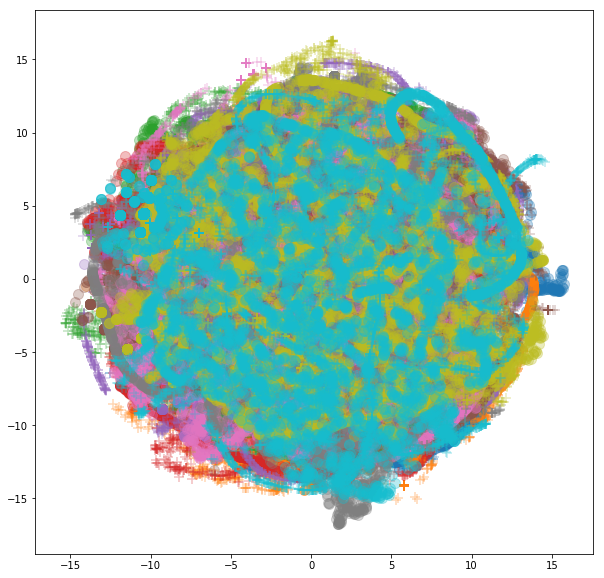

In [24]:
primary_train_embeddings, primary_train_labels = extract_embeddings(primay_train_loader, model, 'primary')
helper_train_embeddings, helper_train_labels = extract_embeddings(helper_train_loader, model, 'helper')


plot_embeddings(primary_train_embeddings, primary_train_labels, helper_train_embeddings, helper_train_labels)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 980 samples in 0.002s...
[t-SNE] Computed neighbors for 980 samples in 0.109s...
[t-SNE] Computed conditional probabilities for sample 980 / 980
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.957573
[t-SNE] Error after 300 iterations: 0.679255
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1744 samples in 0.004s...
[t-SNE] Computed neighbors for 1744 samples in 0.237s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1744
[t-SNE] Computed conditional probabilities for sample 1744 / 1744
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.360905
[t-SNE] Error after 300 iterations: 0.898767
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1135 samples in 0.003s...
[t-SNE] Computed neighbors for 1135 samples in 0.143s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1135
[t-SNE] Co

[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.394421
[t-SNE] Error after 300 iterations: 0.474611
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1595 samples in 0.003s...
[t-SNE] Computed neighbors for 1595 samples in 0.210s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1595
[t-SNE] Computed conditional probabilities for sample 1595 / 1595
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.777264
[t-SNE] Error after 300 iterations: 0.911219


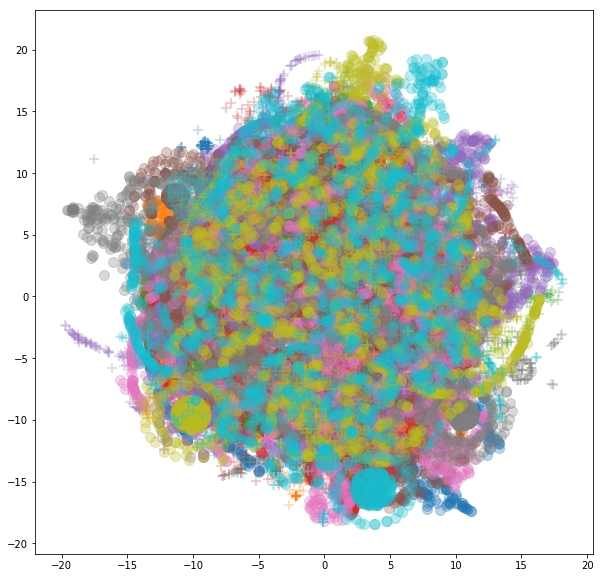

In [25]:
primary_test_embeddings, primary_test_labels = extract_embeddings(primay_test_loader, model, 'primary')
helper_test_embeddings, helper_test_labels = extract_embeddings(helper_test_loader, model, 'helper')


plot_embeddings(primary_test_embeddings, primary_test_labels, helper_test_embeddings, helper_test_labels)

### Conducting the same experiments for 'USPS'

In [26]:
# raw test data, seperate for both the primary and helper class
train_dataset_primary = loadDataset('MNIST', classes, instances,'train')
train_dataset_helper = loadDataset('USPS', classes, instances, 'train' )

# raw test data, seperate for both the primary and helper class
test_dataset_primary = loadDataset('MNIST', classes, instances,'test')
test_dataset_helper = loadDataset('USPS', classes, instances, 'test' )


primay_train_loader = torch.utils.data.DataLoader(train_dataset_primary, batch_size=batch_size, shuffle=True, **kwargs)
helper_train_loader = torch.utils.data.DataLoader(train_dataset_helper, batch_size=batch_size, shuffle=True, **kwargs)

# raw test data, seperate for both the primary and helper class
primay_test_loader = torch.utils.data.DataLoader(test_dataset_primary, batch_size=batch_size, shuffle=True, **kwargs)
helper_test_loader = torch.utils.data.DataLoader(test_dataset_helper, batch_size=batch_size, shuffle=True, **kwargs)

siamese_train_dataset=SiameseCD(train_dataset_primary, train_dataset_helper)
siamese_test_dataset=SiameseCD(test_dataset_primary, test_dataset_helper)


siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

In [27]:
margin = 1.
embedding_net_primary = LeNet(1)
embedding_net_helper = LeNet(1)

model = SiameseNet(embedding_net_primary, embedding_net_helper)
if cuda:
    model.cuda()
loss_fn = ContrastiveLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 100

In [28]:
fit(siamese_train_loader, siamese_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

Train: [0/50000 (0%)]	Loss: 0.127095
Train: [12800/50000 (26%)]	Loss: 0.121978
Train: [25600/50000 (51%)]	Loss: 0.067469
Train: [38400/50000 (77%)]	Loss: 0.042229
Epoch: 1/20. Train set: Average loss: 0.0668
Epoch: 1/20. Validation set: Average loss: 0.0282
Train: [0/50000 (0%)]	Loss: 0.027913
Train: [12800/50000 (26%)]	Loss: 0.026326
Train: [25600/50000 (51%)]	Loss: 0.022088
Train: [38400/50000 (77%)]	Loss: 0.019310
Epoch: 2/20. Train set: Average loss: 0.0211
Epoch: 2/20. Validation set: Average loss: 0.0179
Train: [0/50000 (0%)]	Loss: 0.019290
Train: [12800/50000 (26%)]	Loss: 0.015472
Train: [25600/50000 (51%)]	Loss: 0.013793
Train: [38400/50000 (77%)]	Loss: 0.012451
Epoch: 3/20. Train set: Average loss: 0.0133
Epoch: 3/20. Validation set: Average loss: 0.0136
Train: [0/50000 (0%)]	Loss: 0.012778
Train: [12800/50000 (26%)]	Loss: 0.010419
Train: [25600/50000 (51%)]	Loss: 0.009190
Train: [38400/50000 (77%)]	Loss: 0.009771
Epoch: 4/20. Train set: Average loss: 0.0096
Epoch: 4/20. Valid

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.023s...
[t-SNE] Computed neighbors for 5000 samples in 2.072s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.007001
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.315407
[t-SNE] Error after 300 iterations: 2.319507
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 767 samples in 0.001s...
[t-SNE] Computed neighbors for 767 samples in 0.100s...
[t-SNE] Computed conditional probabilities for sample 767 / 767
[t-SNE] Mean sigma: 0.008506
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.053406
[t-SNE] Error after 300 iterations: 1.150395
[t-SNE] Computing 12

[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.627159
[t-SNE] Error after 300 iterations: 1.688635
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 377 samples in 0.001s...
[t-SNE] Computed neighbors for 377 samples in 0.024s...
[t-SNE] Computed conditional probabilities for sample 377 / 377
[t-SNE] Mean sigma: 0.005652
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.695011
[t-SNE] Error after 300 iterations: 0.558253
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.027s...
[t-SNE] Computed neighbors for 5000 samples in 1.138s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.007191
[t-SNE] KL divergenc

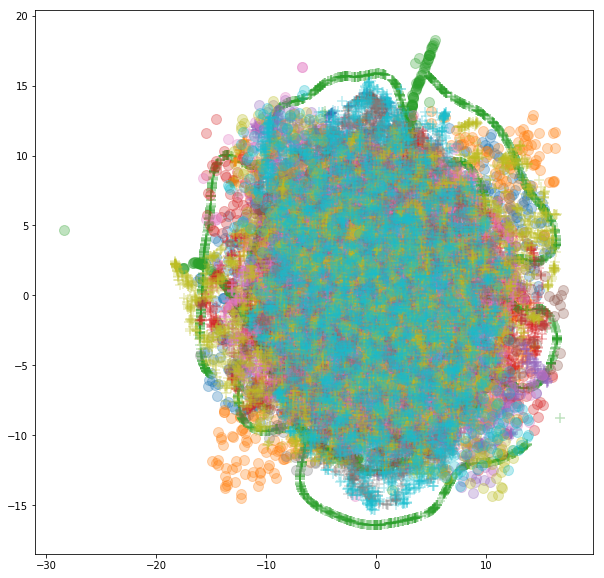

In [29]:
primary_train_embeddings, primary_train_labels = extract_embeddings(primay_train_loader, model, domain='primary')
helper_train_embeddings, helper_train_labels = extract_embeddings(helper_train_loader, model, domain='helper')


plot_embeddings(primary_train_embeddings, primary_train_labels, helper_train_embeddings, helper_train_labels)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 980 samples in 0.003s...
[t-SNE] Computed neighbors for 980 samples in 0.139s...
[t-SNE] Computed conditional probabilities for sample 980 / 980
[t-SNE] Mean sigma: 0.009779
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.890751
[t-SNE] Error after 300 iterations: 1.117883
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 786 samples in 0.002s...
[t-SNE] Computed neighbors for 786 samples in 0.100s...
[t-SNE] Computed conditional probabilities for sample 786 / 786
[t-SNE] Mean sigma: 0.009559
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.262306
[t-SNE] Error after 300 iterations: 1.038841
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1135 samples in 0.003s...
[t-SNE] Computed neighbors for 1135 samples in 0.138s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1135
[t-SNE] Computed conditional probabilities for sample 1135 / 1135
[t-SNE] Mean s

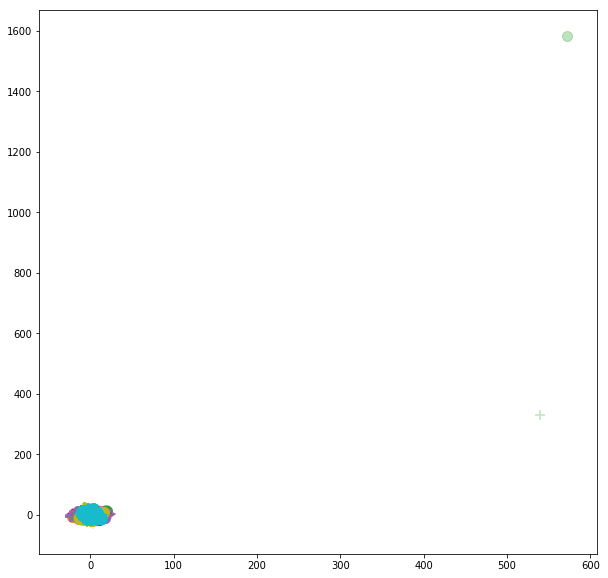

In [30]:
primary_test_embeddings, primary_test_labels = extract_embeddings(primay_test_loader, model, domain='primary')
helper_test_embeddings, helper_test_labels = extract_embeddings(helper_test_loader, model, domain='helper')


plot_embeddings(primary_test_embeddings, primary_test_labels, helper_test_embeddings, helper_test_labels)

### Online Pair Selection 

 We generate pairs/triplets randomly. As the training continues, more and more pairs/triplets are easy to deal with (their loss value is very small or even 0), preventing the network from training. We need to provide the network with **hard examples**.

In [ ]:
from datasets import BalancedBatchSampler

# We'll create mini batches by sampling labels that will be present in the mini batch and number of examples from each class
train_batch_sampler = BalancedBatchSampler(train_dataset, n_classes=10, n_samples=25)
test_batch_sampler = BalancedBatchSampler(test_dataset, n_classes=10, n_samples=25)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
online_train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_batch_sampler, **kwargs)
online_test_loader = torch.utils.data.DataLoader(test_dataset, batch_sampler=test_batch_sampler, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet
from losses import OnlineContrastiveLoss
from utils import AllPositivePairSelector, HardNegativePairSelector # Strategies for selecting pairs within a minibatch

margin = 1.
embedding_net = EmbeddingNet()
model = embedding_net
if cuda:
    model.cuda()
loss_fn = OnlineContrastiveLoss(margin, AllPositivePairSelector(balance=True))
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50

In [ ]:
fit(online_train_loader, online_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)